In [1]:
!hostname

interactive2


In [1]:
%run ../scripts/greedy_partitioner.py

IOError: file `` not found

In [6]:
siteslist = []
pbar = ProgressBar(61100)
for line in open("/hpc/users/neffr01/jason_new/hapcut_outputs/truth_test_methyl_sig_sites.tsv", 'r'):
    pbar.animate()
    chrom, pos, mean1, mean2 = line.strip('\n').split(' ')
    pos, mean1, mean2 = int(pos), float(mean1), float(mean2)
    siteslist.append([chrom, pos, mean1, mean2])

In [8]:
siteslist[-1]

['000000F', 30161039, 2.69464089244, 3.48228381491]

In [2]:
%run ipy_setup.py
%matplotlib inline
from sklearn import mixture
import sklearn
import pysam
import math
from IPython import display
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy import stats
import itertools
import matplotlib.gridspec as gridspec

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

read_bpos = dict()

def get_refmap(bamread):
    bpos = bamread.get_aligned_pairs(matches_only=True)
    positions = [i[0] for i in bpos]
    refpos =  [i[1] for i in bpos] # positions in reference
    refmap = dict(zip(refpos, positions))
    return refmap

def get_matched_bases_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outseq = [bamread.seq[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outseq = ''.join(outseq)
    return outseq

def get_position_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outpos = None
    if in_pos in refmap:
        outpos = refmap[in_pos]
    return outpos

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C', 
                 'N':'N'}
    return ''.join([translate[s] for s in seq])

In [5]:
motifs_in = open('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/ipds/hg002_ipds_priors_merged_000000F.sort.dedup.tsv', 'rb')
motif_dict = dict()
pbar = ProgressBar(3201285)
for line in motifs_in:
    pbar.animate()
    motif,data = line.strip('\n').split('\t')
    motif_dict[motif] = data

[*****************99%******************]  3170900 of 3201285 complete Elapsed: 1.7 minutes	 Remaining: 0.0 minutes


In [ ]:
bam_fp = pysam.AlignmentFile("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hg002.000000F.het_sites_truth_partition_snps_only.bam", "rb")
#out_fp = pysam.AlignmentFile("~/jason_new/hapcut_outputs/hg002_re_000000F/hg002_methyl_phased-from-trio-data_000000F.bam", 'wb')
out_predict = open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_vs_truth.tsv", "w")
predictions = []
pbar = ProgressBar(170000)

for read in bam_fp.fetch(region="000000F", start=0, end=30161039):
    pbar.animate()
    rstart, rend = read.pos, read.aend
    sigoverlap = [i for i in siteslist if (i[1] <= rend) & (i[1] >= rstart)]
    if len(sigoverlap) == 0:
        continue
    refmap = get_refmap(read)
    ipd_values = [int(i) for i in read.get_tag('ip').strip('S').split(',')]
    #hap = int(read.get_tag('ZH').split(";")[0].split(",")[1])
    hap = read.get_tag('ZH')
    pv = read.get_tag('ZV')
    res = []
    for row in sigoverlap:
        refpos = row[1]
        basepos = get_position_in_read(read, refpos, refmap)
        if basepos==None: continue
        ipd_value = np.log(ipd_values[basepos])
        #motif = refseq[refpos-5-(rstart):refpos+6-rstart]
        #ref_3mer = motif[4:7]
        #read_3mer = get_matched_bases_in_read(read, range(refpos-1,refpos+2), refmap)
        #if ref_3mer != read_3mer: continue
        res.append([abs(row[2]-ipd_value), abs(row[3]-ipd_value)])
    if res != []:
        #print read.qname
        hap1_res = sum([i[0] for i in res])
        hap2_res = sum([i[1] for i in res])
        predict_hap = None
        if hap1_res > hap2_res:
            predict_hap = 2
        else:
            predict_hap = 1
        #print "Predicted:\t", predict_hap, "actual:\t", hap
        predictions.append([predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen])
        print >>out_predict, predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen
        out_predict.flush()

[                  0%                  ]

n= 706


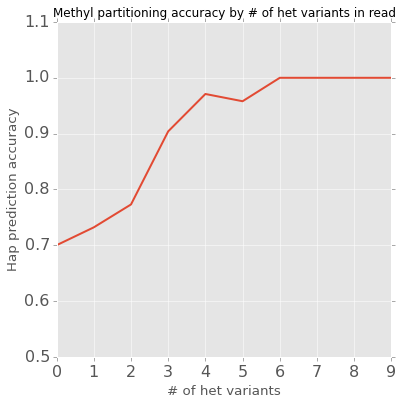

In [98]:
predictions = []
for line in open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_denovo_vs_truth.tsv", 'r'):
    predline = line.strip('\n').split(' ')
    predline = [float(i) for i in predline]
    predictions.append(predline)
print "n=", len(predictions)
rcParams['figure.figsize'] = (6, 6)
rcParams['axes.titlesize'] = 12
pltarr = []
for var in range(0,20):
    predcheck = [i for i in predictions if i[3] > var]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if i[0] == i[1] else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    #print "partition variants >=", var, "prediction acc:", acc , "n=", n
plt.title("Methyl partitioning accuracy by # of het variants in read")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([.5,1.1])
plt.xlabel("# of het variants", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

In [ ]:
-------------------------------------
  -         -          -           -
1 4         2          1           2 = 9 == haplotype 1 read
2 8         3          5           7 = 23

n= 663


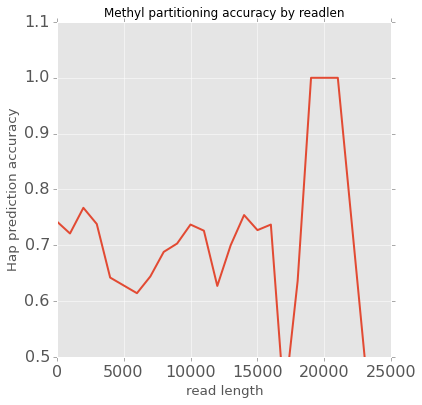

In [97]:
predictions = []
for line in open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_denovo_vs_truth.tsv", 'r'):
    predline = line.strip('\n').split(' ')
    predline = [float(i) for i in predline]
    predictions.append(predline)
rcParams['figure.figsize'] = (6, 6)
rcParams['axes.titlesize'] = 12
pltarr = []
print "n=", len(predictions)
for var in range(0,35000,1000):
    predcheck = [i for i in predictions if (i[6] > var) & (i[6] < var+2000)]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if i[0] == i[1] else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    #print "partition variants >=", var, "prediction acc:", acc , "n=", n
plt.title("Methyl partitioning accuracy by readlen")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([0.5,1.1])
plt.xlabel("read length", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

n= 140154


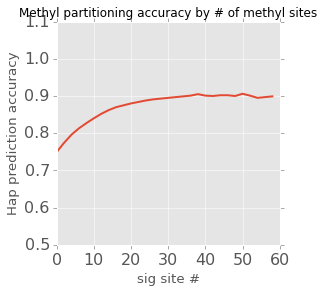

In [6]:
'''predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen'''

predictions = []
for line in open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_vs_truth.tsv", 'r'):
    predline = line.strip('\n').split(' ')
    predline = [float(i) for i in predline]
    predictions.append(predline)
rcParams['figure.figsize'] = (4, 4)
rcParams['axes.titlesize'] = 12
pltarr = []
t = len(predictions)
print "n=", len(predictions)
for var in range(0,60,2):
    predcheck = [i for i in predictions if (i[2] > var) & (i[2] < var+10)]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if i[0] == i[1] else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    #print "partition variants >=", var, "prediction acc:", acc , "n %", n/float(t)*100
plt.title("Methyl partitioning accuracy by # of methyl sites")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([0.5,1.1])
plt.xlabel("sig site #", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

n= 140154


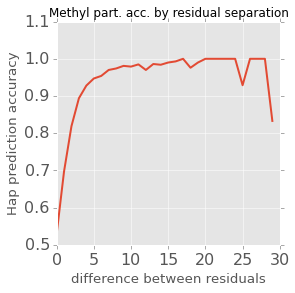

In [10]:
'''predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen'''

predictions = []
for line in open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_vs_truth.tsv", 'r'):
    predline = line.strip('\n').split(' ')
    predline = [float(i) for i in predline]
    predictions.append(predline)
rcParams['figure.figsize'] = (4, 4)
rcParams['axes.titlesize'] = 12
pltarr = []
print "n=", len(predictions)
for var in range(0,30,1):
    predcheck = [i for i in predictions if (i[2] >= 10) & (i[2] <= 30)]
    predcheck = [i for i in predcheck if (abs(i[5]-i[4]) > var) & (abs(i[5]-i[4]) < (var+1))]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if i[0] == i[1] else 0 for i in predcheck]), 3)
    rescount = np.mean([i[2] for i in predcheck])
    n = len(predcheck)
    pltarr.append([var, acc, n])
    #print "partition variants >=", var, "prediction acc:", acc , "n=", n
plt.title("Methyl part. acc. by residual separation")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
#plt.ylim([0.5,1.1])
#plt.xlim([22.807067, 22.80707])
plt.xlabel("difference between residuals", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

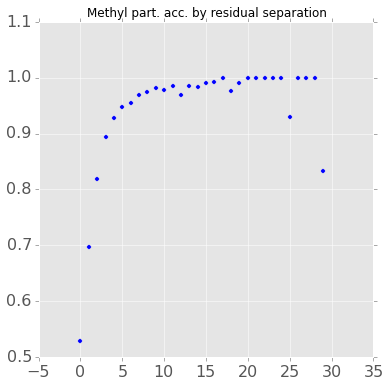

In [163]:
plt.title("Methyl part. acc. by residual separation")
plt.scatter([i[0] for i in pltarr], [i[1] for i in pltarr])
#plt.ylim([0.5,1.1])
#plt.xlim([22.807067, 22.80707])
#plt.xlabel("difference between residuals", fontsize='small')
#plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

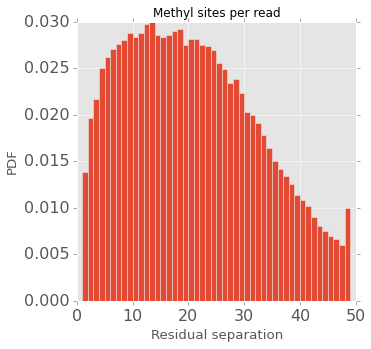

In [16]:
rcParams['figure.figsize'] = (5, 5)
plt.hist([i[2] for i in predictions], bins=range(0,50,1), normed=True)
plt.title("Methyl sites per read")
plt.xlabel("Residual separation", fontsize="small")
plt.ylabel("PDF", fontsize="small")
plt.show()

In [118]:
def toPhred(val):
    return chr(int(-10*np.log10(val)) + 33), int(-10*np.log10(val))

In [265]:
toPhred(0.25)

("'", 6)

In [264]:
from scipy import stats

In [ ]:
stats.norm

In [262]:
def dummyScore(log_val, prior_mean_hap1, prior_mean_hap2):
    zscore1 = abs(log_val - prior_mean_hap1)/1.5 # dummy SD, fixed for all
    pval1 = sp.stats.norm.sf(zscore1)
    zscore2 = abs(log_val - prior_mean_hap2)/1.5 # dummy SD, fixed for all
    pval2 = sp.stats.norm.sf(zscore2)
    pval_hap1_nothap2 = (pval1 * (1-pval2))/(pval1*(1-pval2) + pval2*(1-pval1)) # p(hap1) * (1-p(hap2)) = P(hap1|not hap2)
    pval_hap2_nothap1 = (pval2 * (1-pval1))/(pval2*(1-pval1) + pval1*(1-pval2)) # p(hap1) * (1-p(hap2)) = P(hap1|not hap2)
    print pval_hap1_nothap2, pval_hap2_nothap1
    if pval_hap2_nothap1 > pval_hap1_nothap2:
        return 2, toPhred(pval_hap1_nothap2)
    else:
        return 1, toPhred(pval_hap2_nothap1)

In [263]:
dummyScore(2.0,2.0,3.5)

0.841344746069 0.158655253931


(1, ('(', 7))